In [ ]:
#teste

import lightkurve as lk
import numpy as np 
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
import warnings


In [ ]:
warnings.filterwarnings("ignore")


df_estrelas = pd.read_csv("estrelas_variaveiss.csv")
df_estrelas_880 = df_estrelas.iloc[:5].copy()
df_estrelas_880['TIC'] = df_estrelas['tess_id'].apply(lambda x: f"TIC {x}")
tics = list(df_estrelas_880['TIC'])

In [19]:

all_flares = []

for TIC in tics:
    try:
        # Baixar e unir curvas de luz
        lc_collection = lk.search_lightcurve(TIC, author="SPOC").download_all()
        if lc_collection is None:
            print(f"Nenhum dado encontrado para {TIC}")
            continue
        
        lc = lc_collection.stitch().remove_nans().normalize()
        
        tempo = lc.time.value
        fluxo = lc.flux.value
        
        if len(fluxo) < 10:
            continue
        
        # Detrending 
        window_length = min(101, len(fluxo)//2*2+1)
        trend = savgol_filter(fluxo, window_length=window_length, polyorder=3)
        flux_detrend = fluxo / trend - 1
        flux_detrend = np.ravel(flux_detrend).astype(np.float64)
        
        #Detecção de flares 
        sigma = np.std(flux_detrend)
        limiar = 3 * sigma
        peaks, _ = find_peaks(flux_detrend)
        peaks = [p for p in peaks if flux_detrend[p] > limiar]
        
        for p in peaks:
            amp = flux_detrend[p]
            start = p
            while start > 0 and flux_detrend[start] > 0.1*amp:
                start -= 1
            end = p
            while end < len(flux_detrend)-1 and flux_detrend[end] > 0.1*amp:
                end += 1
            energia = np.sum(flux_detrend[start:end])
            duracao = tempo[end] - tempo[start]
            
            all_flares.append({
                "tic_id": TIC,
                "tempo_inicio": tempo[start],
                "tempo_pico": tempo[p],
                "tempo_fim": tempo[end],
                "amplitude": amp,
                "energia": energia,
                "duracao": duracao
            })
        
        print(f"{TIC} processado, {len(peaks)} flares detectados.")
    
    except Exception as e:
        print(f"Erro com {TIC}: {e}")


TIC 99920728 processado, 296 flares detectados.
TIC 99824805 processado, 270 flares detectados.
TIC 99817388 processado, 11 flares detectados.
TIC 99785582 processado, 93 flares detectados.
TIC 99784331 processado, 5 flares detectados.
Tabela detalhada salva em 'flares_detalhadoss.csv'.
Tabela resumida salva em 'flares_resumidos.csv'.


In [ ]:
# Criar DataFrame detalhado
df_flares = pd.DataFrame(all_flares)
df_flares.to_csv("flares_detalhadoss.csv", index=False)
print("Tabela detalhada salva em 'flares_detalhadoss.csv'.")

In [ ]:
# Criar DataFrame resumido por TIC
df_summary = df_flares.groupby('tic_id').agg(
    n_flares=('tempo_pico','count'),
    amplitude_max=('amplitude','max'),
    amplitude_media=('amplitude','mean'),
    energia_max=('energia','max'),
    energia_media=('energia','mean'),
    duracao_media=('duracao','mean')
).reset_index()
df_summary.to_csv("flares_resumidoss.csv", index=False)
print("Tabela resumida salva em 'flares_resumidos.csv'.")

In [3]:
# Remover espaços ou caracteres não numéricos e converter
df_summary['energia_max'] = pd.to_numeric(df_summary['energia_max'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
df_summary['energia_media'] = pd.to_numeric(df_summary['energia_media'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
df_summary['amplitude_max'] = pd.to_numeric(df_summary['amplitude_max'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
df_summary['amplitude_media'] = pd.to_numeric(df_summary['amplitude_media'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
df_summary['duracao_media'] = pd.to_numeric(df_summary['duracao_media'].astype(str).str.replace(',', '.').str.strip(), errors='coerce')


In [4]:
# Converter colunas numéricas em df_flares
cols_numeric = ['amplitude', 'duracao', 'energia']

for col in cols_numeric:
    df_flares[col] = pd.to_numeric(df_flares[col].astype(str).str.replace(',', '.').str.strip(), errors='coerce')


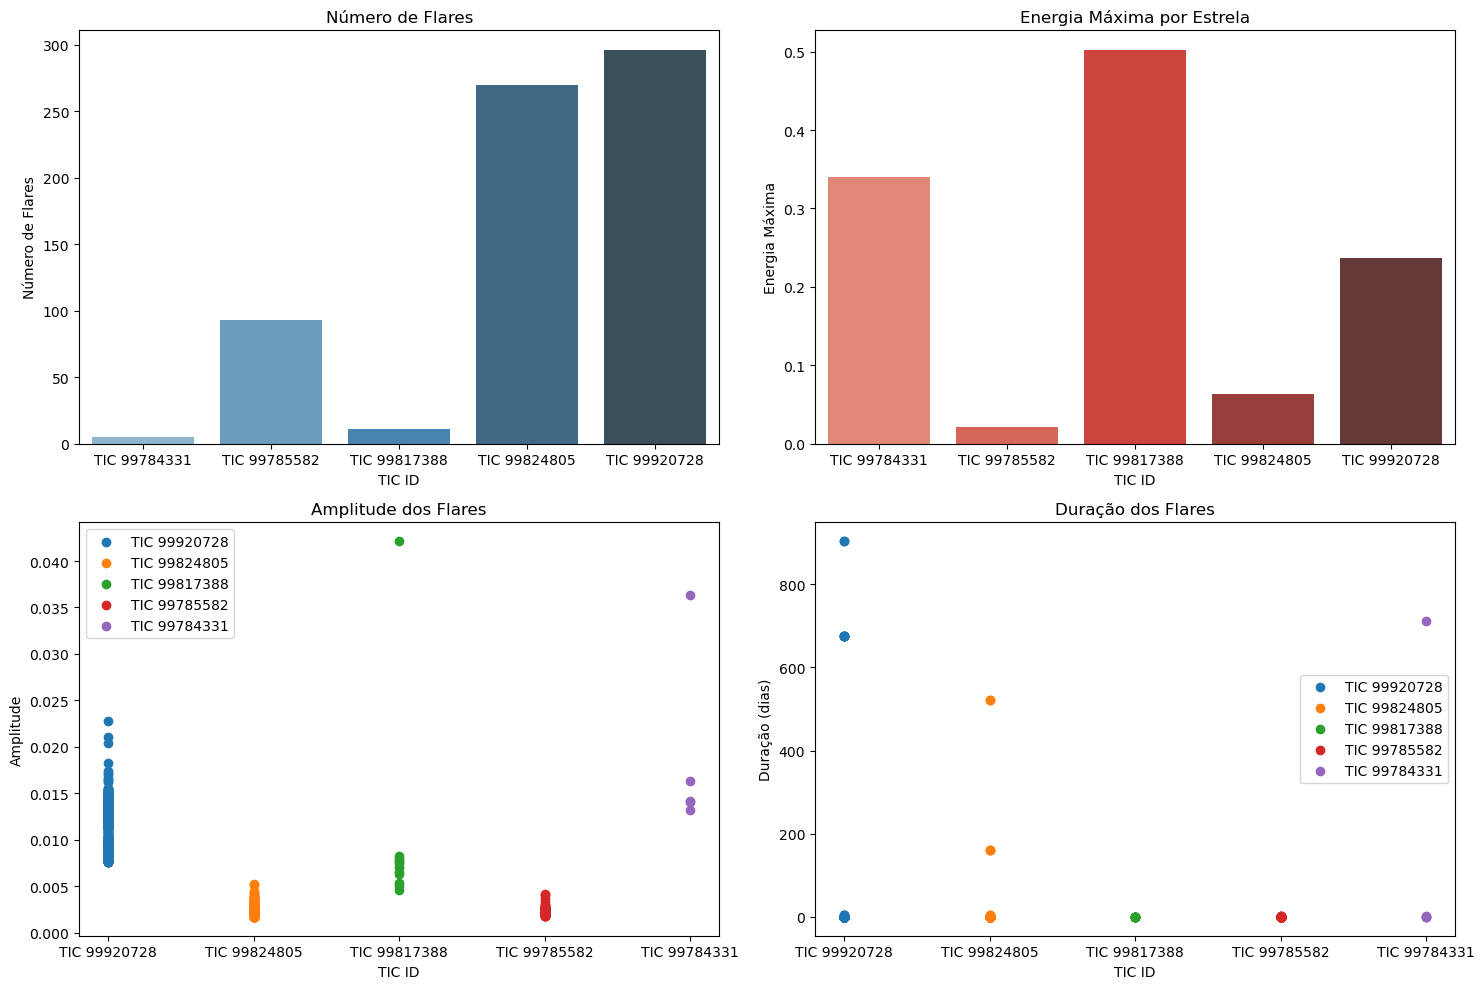

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2,2, figsize=(15,10))

# Número de Flares por estrela (bar plot)
sns.barplot(x='tic_id', y='n_flares', data=df_summary, palette="Blues_d", ax=axes[0,0])
axes[0,0].set_title("Número de Flares")
axes[0,0].set_xlabel("TIC ID")
axes[0,0].set_ylabel("Número de Flares")

# Energia Máxima por estrela (bar plot)
sns.barplot(x='tic_id', y='energia_max', data=df_summary, palette="Reds_d", ax=axes[0,1])
axes[0,1].set_title("Energia Máxima por Estrela")
axes[0,1].set_xlabel("TIC ID")
axes[0,1].set_ylabel("Energia Máxima")

# Scatter plot: Amplitude de cada flare por estrela
for tic in df_flares['tic_id'].unique():
    subset = df_flares[df_flares['tic_id'] == tic]
    axes[1,0].scatter([tic]*len(subset), subset['amplitude'], label=str(tic))
axes[1,0].set_title("Amplitude dos Flares")
axes[1,0].set_xlabel("TIC ID")
axes[1,0].set_ylabel("Amplitude")
axes[1,0].legend()

# Scatter plot: Duração de cada flare por estrela
for tic in df_flares['tic_id'].unique():
    subset = df_flares[df_flares['tic_id'] == tic]
    axes[1,1].scatter([tic]*len(subset), subset['duracao'], label=str(tic))
axes[1,1].set_title("Duração dos Flares")
axes[1,1].set_xlabel("TIC ID")
axes[1,1].set_ylabel("Duração (dias)")
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [14]:
limiar_superflare = 0.1 
superflares = df_flares[df_flares['energia'] >= limiar_superflare]
print(superflares)
df_flares['super_flare'] = df_flares['energia'] > 0.01  # exemplo de threshold


           tic_id  tempo_inicio   tempo_pico    tempo_fim  amplitude  \
0    TIC 99920728   1684.392244  1684.408910  1684.429743   0.012169   
1    TIC 99920728   1684.392244  1684.411688  1684.429743   0.013007   
2    TIC 99920728   1684.492242  1684.499186  1684.528353   0.012401   
3    TIC 99920728   1684.492242  1684.504742  1684.525575   0.013040   
4    TIC 99920728   1684.492242  1684.510297  1684.525575   0.013365   
..            ...           ...          ...          ...        ...   
670  TIC 99784331   1883.997871  1886.917292  1886.945069   0.016307   
671  TIC 99784331   1897.760128  1897.785127  2609.922558   0.036332   
672  TIC 99784331   2614.587830  2614.605885  2614.632274   0.014075   
673  TIC 99784331   2614.689218  2614.708663  2614.748940   0.014163   
674  TIC 99784331   2614.689218  2614.712829  2614.748940   0.013169   

      energia     duracao  super_flare  
0    0.189434    0.037499         True  
1    0.189434    0.037499         True  
2    0.20507

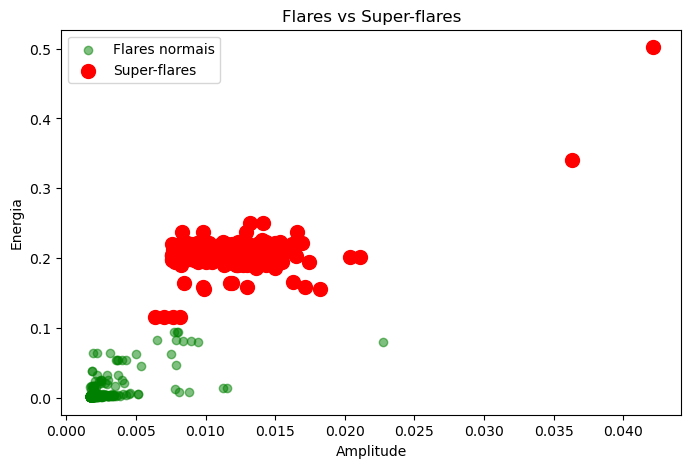

In [15]:
plt.figure(figsize=(8,5))

# Todos os flares
plt.scatter(df_flares['amplitude'], df_flares['energia'], color='green', label='Flares normais', alpha=0.5)

# Super-flares
plt.scatter(superflares['amplitude'], superflares['energia'], color='red', label='Super-flares', s=100)

plt.xlabel("Amplitude")
plt.ylabel("Energia")
plt.title("Flares vs Super-flares")
plt.legend()
plt.show()


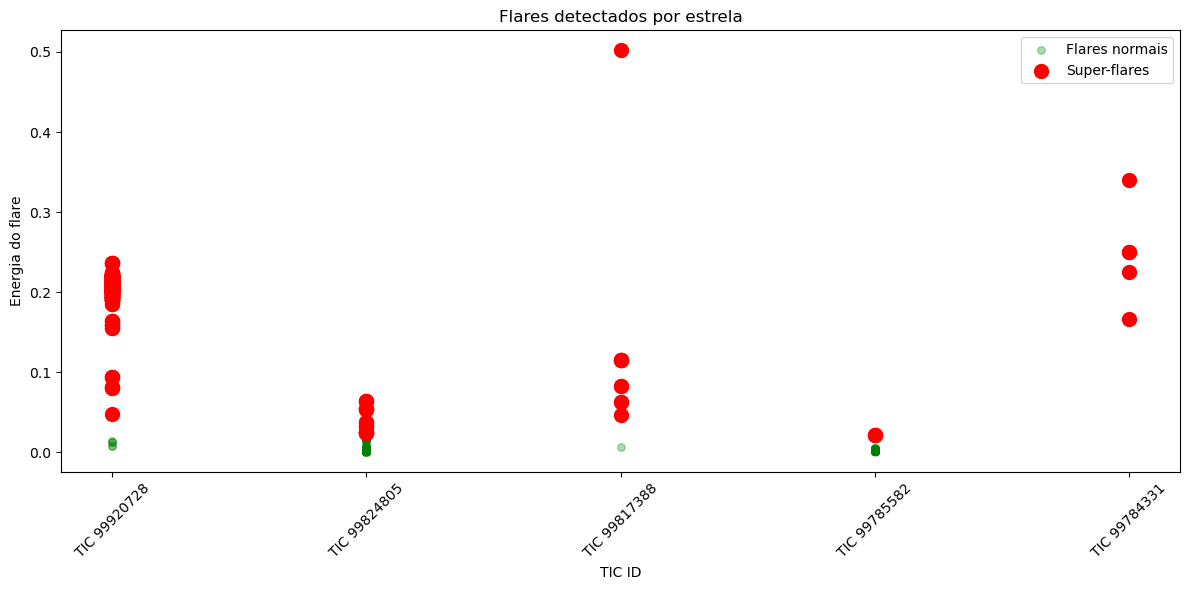

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,6))

# Mapear TICs para posições numéricas
tics = df_flares['tic_id'].unique()
tic_to_num = {tic:i for i, tic in enumerate(tics)}

# Scatter para flares normais
x = df_flares['tic_id'].map(tic_to_num)  # posição no eixo X
plt.scatter(x, df_flares['energia'], color='green', alpha=0.3, s=30, label='Flares normais')

# Scatter para super-flares
if 'super_flare' in df_flares.columns:
    x_super = df_flares['tic_id'][df_flares['super_flare']].map(tic_to_num)
    plt.scatter(x_super, df_flares['energia'][df_flares['super_flare']],
                color='red', s=100, label='Super-flares')

# Ajustar eixo X com nomes dos TICs
plt.xticks(range(len(tics)), tics, rotation=45)
plt.xlabel("TIC ID")
plt.ylabel("Energia do flare")
plt.title("Flares detectados por estrela")
plt.legend()
plt.tight_layout()
plt.show()
